- Update log
  - 6.12
    - 增加了通过均值方差生成theta的theta_gen，但发现很难精准控制值
      - 预计仍旧采用随机采样分析  
      - 可以考虑在特定区间，如theta in  [0.01,0.1]，进行分析
    - TS算法完工
    - 可视化
      - 统计了对于无明显特征的theta组，采用1000量级的先验参数误差较小（效果最好）的次数最多
    -  可能的目标
       -  直接将1000量级的实验结果取出，和另外两个算法的最优比较（只比较均值，所以是柱状图；只比较排名第一次数，所以也是柱状图）
       -  将theta的区间从[0,1]转换为[0.001,0.1]，再度进行一个完整流程的探索
  - 6.13 
    - 根据数学求解，完成拥有特征：均值、标准差 、theta1的thetaSeq

## Theta Generate & ThetaSequence Definition

In [261]:
## specific_theta_geneta
import numpy as np
import matplotlib.pyplot as plt

class ThetaSequence:
    def __init__(self, seq: np.ndarray, n_elements: int):
        self.seq = seq
        self.n_elem = n_elements
        self.mean = np.mean(seq)
        self.var = np.var(seq)
        self.max_theta = np.max(seq)

## randomly generate
def generate_theta_sequence_set(n_elem, n_sets):
    theta_seq_set = []
    for _ in range(n_sets):
        theta_seq = ThetaSequence(np.random.uniform(0, 1, size=n_elem), n_elem)
        theta_seq_set.append(theta_seq)
    return np.array(theta_seq_set)

## 用theta组的数值特征，判断不同参数对不同特征的适应性
## 每个theta 跑200次，每次5000下摇杆

## 数值大小随意，数值特征重要
# 均值0.05为跨度，标准差1/20为跨度

## 6.12更新
# ## 使用固定的均值、标准差，生成n和数据（theta_seq）
# def specific_theta_generate(mean, std_dev, n):
#   # np.random.seed(0)  # 设置随机种子以确保结果可复现
#   flag = False
#   while not flag:
#     flag = True
#     theta_array = np.random.normal(loc=mean, scale=std_dev, size=n)
#     for i in theta_array:
#       if i <= 0 or i >=1:
#         flag = False
#         break
#   return ThetaSequence(theta_array,n)

## 6.13更新
## 由数学关系得到具有特征 theta1，均值，标准差的thetaSeq
## 不需要输入数字，因为只能生成三个
def specific_theta_generate(mean, std_dev, theta1 = np.random.uniform(0,1)):
    coff_a = 2
    coff_b = 2 * theta1 - 6 * mean 
    coff_c = 6 * (mean ** 2) - 3 * (std_dev ** 2) + 2 * (theta1 ** 2) - 6 * mean * theta1
    ## 我们输出两根中更大的一个
    theta2 = (-coff_b + np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)
    theta3 = 3 * mean - theta1 - theta2    
    theta4 = (-coff_b - np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)
    while (coff_b ** 2 - 4 * coff_a * coff_c < 0 or theta2 <= 0 or theta2 >=1 or theta3 <= 0 or theta3 >=1):
        theta1 = np.random.uniform(0,1)
        coff_a = 2
        coff_b = 2 * theta1 - 6 * mean 
        coff_c = 6 * (mean ** 2) - 3 * (std_dev ** 2) + (2 * theta1 ** 2) - 6 * mean * theta1  
        theta2 = (-coff_b + np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)
        theta3 = 3 * mean - theta1 - theta2    
        theta4 = (-coff_b - np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)
    
    print(theta4)
    return ThetaSequence(np.array([theta1,theta2,theta3]),3)
    # theta 中更小的那个的表达式：(-coff_b - np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)


## 静均值，动标准差
def theta_generate_static_mean_rolling_std_dev(size, mean, start_std_dev, end_std_dev, span):
  theta_set = []
  for rolling_std_dev in np.arange(start_std_dev, end_std_dev, span):
     theta_set.append(specific_theta_generate(mean, rolling_std_dev, size))
  return np.array(theta_set)

## 静标准差，动均值
def theta_generate_static_std_dev_rolling_mean(size, std_dev, start_mean, end_mean, span):
  theta_set = []
  for rolling_mean in np.arange(start_mean, end_mean, span):
     theta_set.append(specific_theta_generate(rolling_mean, std_dev, size))
  return np.array(theta_set)


func = specific_theta_generate(0.4,np.sqrt(0.2))

print(func.seq,func.mean,func.var, 0.2)


KeyboardInterrupt: 

In [8]:
## Test Field

# 已知的均值和方差
known_mean = 0.5
known_var = 1/6


print(theta_generate_static_mean_rolling_std_dev(3,known_mean,known_var,0.9,0.1)[2].mean)



NameError: name 'theta_generate_static_mean_rolling_std_dev' is not defined

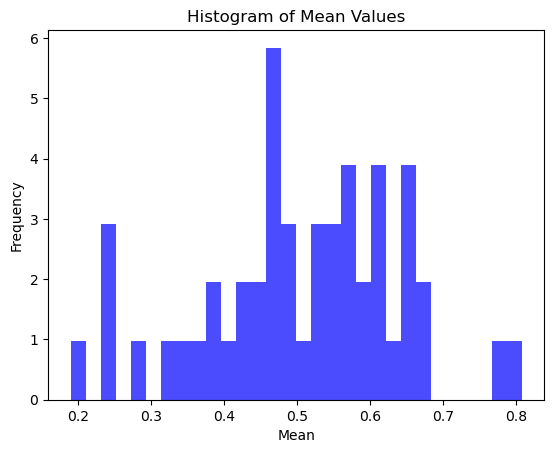

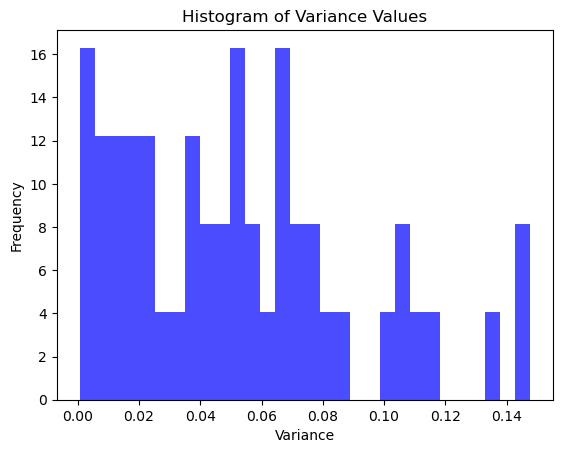

In [15]:
## Gen Field
n_elem = 3
n_sets = 50

theta_seq_set = generate_theta_sequence_set(n_elem, n_sets)

# 提取 ThetaSequence 对象的 mean 属性作为数据序列
mean_values = [theta_seq.mean for theta_seq in theta_seq_set]
plt.hist(mean_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values')
plt.show()

# 提取 ThetaSequence 对象的 variance 属性作为数据序列
variance_values = [theta_seq.var for theta_seq in theta_seq_set]
plt.hist(variance_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Variance Values')
plt.show()

## Beta Prio Gen

In [16]:
def beta_prio_generate(theta_seq_set: np.ndarray, min_n_trails: int):
  para_set_min = []
  para_set_10_min = []
  para_set_100_min = []
  for theta_seq in theta_seq_set:
    ## 以下针对一组thetaSeq
    for k in range(3):
      para = []
      for theta in theta_seq.seq:
        res = np.random.binomial(1, theta, (10 ** k)*min_n_trails)
        para.append([np.sum(res), (10 ** k)*min_n_trails - np.sum(res)])
      if k==0:
        para_set_min.append(para)
      elif k==1:
        para_set_10_min.append(para)
      else:
        para_set_100_min.append(para)

  return np.array(para_set_min), np.array(para_set_10_min), np.array(para_set_100_min)
  
## 性能优化：所有数组先申请好成1，最后再增加
para_exp_0, para_exp_1, para_exp_2 = beta_prio_generate(theta_seq_set, min_n_trails=10)

## 针对性的一次TS

I'm calculating, plz wait.
4505.5 4627.4 4619.0 4531.0
    delta: 121.9 113.5 25.5
Theta-Var: 0.1037   best-arm: 3

3740.9 3738.6 3260.8 3956.0
   delta: -2.3 -480.1 215.1
Theta-Var: 0.0852   best-arm: 1

3450.9 3651.2 3265.8 3390.8
  delta: 200.3 -185.1 -60.1
Theta-Var: 0.0324   best-arm: 3

4882.4 4675.2 4839.8 4904.4
   delta: -207.2 -42.6 22.0
Theta-Var: 0.1465   best-arm: 3

3997.8 4685.8 3977.8 3937.0
   delta: 688.0 -20.0 -60.8
Theta-Var: 0.0725   best-arm: 2

3628.1 3759.6 3532.8 3645.2
    delta: 131.5 -95.3 17.1
Theta-Var: 0.0564   best-arm: 3

2842.9 3679.0 2677.2 2628.4
 delta: 836.1 -165.7 -214.5
Theta-Var: 0.0167   best-arm: 2

4300.7 4905.0 3999.0 4293.4
   delta: 604.3 -301.7 -7.3
Theta-Var: 0.0804   best-arm: 3

2679.7 3169.2 2760.6 2615.4
    delta: 489.5 80.9 -64.3
Theta-Var: 0.0011   best-arm: 3

4039.3 3825.6 4205.6 3914.8
 delta: -213.7 166.3 -124.5
Theta-Var: 0.0393   best-arm: 3

2972.1 4342.0 3427.6 3074.8
  delta: 1369.9 455.5 102.7
Theta-Var: 0.0575   best-ar

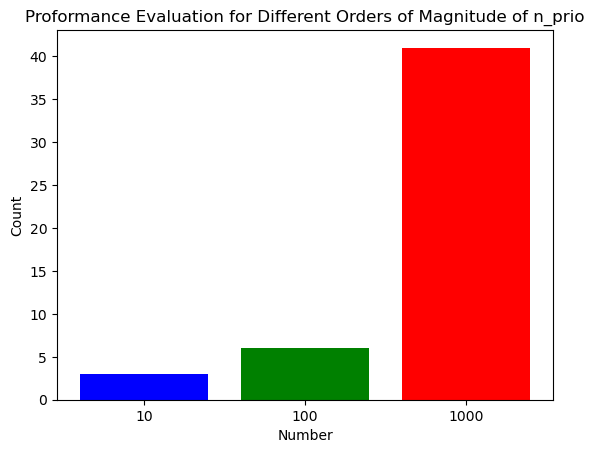

In [17]:
## 参数修正后的TS

## 问题是没有得到最终的策略
def Thompson_Sampling_once(n_arms, n_trials, beta_prio):
  ## 手动都进行+1
  for i in range(n_arms):
    beta_prio[i][0] += 1
    beta_prio[i][1] += 1
  sampled_theta = np.zeros(n_arms)
  reward = np.zeros(n_arms, dtype=int)
  for _ in range(n_trials):
    for i in range(n_arms):
      sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])
    max_arm = np.argmax(sampled_theta)
    cor_reward = np.random.binomial(1, sampled_theta[max_arm])
    beta_prio[max_arm][0] += cor_reward
    beta_prio[max_arm][1] +=  (1 - cor_reward) 
    reward[max_arm] += cor_reward

  for i in range(n_arms):
    ## final update
    sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])  
  # print(np.sum(reward))
  return np.sum(reward)       ##, sampled_theta   这里就不输出了

final_reward_para_exp_0 = []
final_reward_para_exp_1 = []
final_reward_para_exp_2 = []


print("I'm calculating, plz wait.")
for i in range(len(theta_seq_set)):
  ## 对第i组theta做500次实验，取平均
  reward_0, reward_1, reward_2 = [], [], []

  ## 5次实验，5000 time slots，否则真有点久
  for j in range(5):
    reward_0.append(Thompson_Sampling_once(3, 5000, para_exp_0[i]))
    reward_1.append(Thompson_Sampling_once(3, 5000, para_exp_1[i]))
    reward_2.append(Thompson_Sampling_once(3, 5000, para_exp_2[i]))
  final_reward_para_exp_0.append(np.mean(np.array(reward_0)))
  final_reward_para_exp_1.append(np.mean(np.array(reward_1)))
  final_reward_para_exp_2.append(np.mean(np.array(reward_2)))


# for i in range(len(theta_seq_set)):
#   print(str(theta_seq_set[i].max_theta * 5000)+" "+str(final_reward_para_exp_0[i])+" "+str(final_reward_para_exp_1[i])+" "+str(final_reward_para_exp_2[i]))
#   print("delta:" + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000))

# print(final_reward_para_exp_0)
# print(final_reward_para_exp_1)
# print(final_reward_para_exp_2)
magnitude_performance_static=[]
for i in range(len(theta_seq_set)):
    # 获取格式化的原数值字符串
    values_str = "{:.1f} {:.1f} {:.1f} {:.1f}".format(
        theta_seq_set[i].max_theta * 5000,
        final_reward_para_exp_0[i],
        final_reward_para_exp_1[i],
        final_reward_para_exp_2[i]
    )
    
    # 计算各delta值
    delta_0 = final_reward_para_exp_0[i] - theta_seq_set[i].max_theta * 5000
    delta_1 = final_reward_para_exp_1[i] - theta_seq_set[i].max_theta * 5000
    delta_2 = final_reward_para_exp_2[i] - theta_seq_set[i].max_theta * 5000
    
    # 获取格式化的delta字符串
    delta_str = "delta: {:.1f} {:.1f} {:.1f}".format(delta_0, delta_1, delta_2)
    delta = [abs(delta_0),abs(delta_1),abs(delta_2)]
    # 打印原数值和delta，保证delta字符串右对齐
    print(values_str)
    print(delta_str.rjust(len(values_str)))
    print("Theta-Var: {:.4f}   best-arm: {:1}".format(theta_seq_set[i].var, 1+np.argmin([delta])))
    magnitude_performance_static.append(1+np.argmin([delta]))
    print()
    ## 统计个数？

# 统计1，2，3的个数
count_10 = magnitude_performance_static.count(1)
count_100 = magnitude_performance_static.count(2)
count_1000 = magnitude_performance_static.count(3)

# 打印统计结果
print(f"Count of 1: {count_10}")
print(f"Count of 2: {count_100}")
print(f"Count of 3: {count_1000}")

# 准备绘图数据
labels = ['10', '100', '1000']
counts = [count_10, count_100, count_1000]

# 绘制条形图
plt.bar(labels, counts, color=['blue', 'green', 'red'])

# 设置标题和标签
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Proformance Evaluation for Different Orders of Magnitude of n_prio') #先验个数数量级（10，100，1000）

# 显示图表
plt.show()
